In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import pandas as pd
import numpy as np
import os
import random
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns


df_orig = pd.read_pickle('df_orig.pickle')


def sentence_labels(df_orig):
    sentences = []
    labels = []
    df_sent_groups = df_orig.groupby('PMID')
    i=0
    for name, group in df_sent_groups: # no order
#         if i==0:
#             print(name)
#             print(group)
#             i+=1
        group_labs = group.Gold.tolist()
        s = group.head(1).abstract.tolist()
        sentences.append(s)
        labels.append(group_labs)
    
    return sentences, labels

# two lists of all abstracts in all files and all labels for each abtract
sentences, labels = sentence_labels(df_orig)



In [2]:
sentence_label_pairs = [(s[0], l) for (s, l) in list(zip(sentences, labels)) if len(l)>1]


In [3]:

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


MAX_LEN = 150
bs = 32

tag_values = ['0', '1', 'PAD']
tag2idx = {'0': 0, '1': 1, 'PAD': 2}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', do_lower_case=False)

tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs) # sent[0] or just sent??? MB a bug!
    for sent, labs in sentence_label_pairs
]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [7]:
count = 0
for listElem in tokenized_texts:
    count += len(listElem)   
count

1665815

In [13]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint 

Average train loss: 0.4350622982015585
Validation loss: 0.3810057345612464
Validation Accuracy: 0.8620845484562917
Validation Precision-Score: 0.8620845484562917
Validation Recall-Score: 0.8620845484562917


Epoch:  33%|███▎      | 1/3 [03:04<06:08, 184.48s/it]

Validation F1-Score: 0.8620845484562917

Average train loss: 0.3741711210268756
Validation loss: 0.36167812205011934
Validation Accuracy: 0.8651213516184233
Validation Precision-Score: 0.8651213516184233
Validation Recall-Score: 0.8651213516184233


Epoch:  67%|██████▋   | 2/3 [06:10<03:05, 185.52s/it]

Validation F1-Score: 0.8651213516184234

Average train loss: 0.3673365846047426
Validation loss: 0.35691833623236763
Validation Accuracy: 0.8661667590561809
Validation Precision-Score: 0.8661667590561809
Validation Recall-Score: 0.8661667590561809


Epoch: 100%|██████████| 3/3 [09:16<00:00, 185.60s/it]

Validation F1-Score: 0.8661667590561809



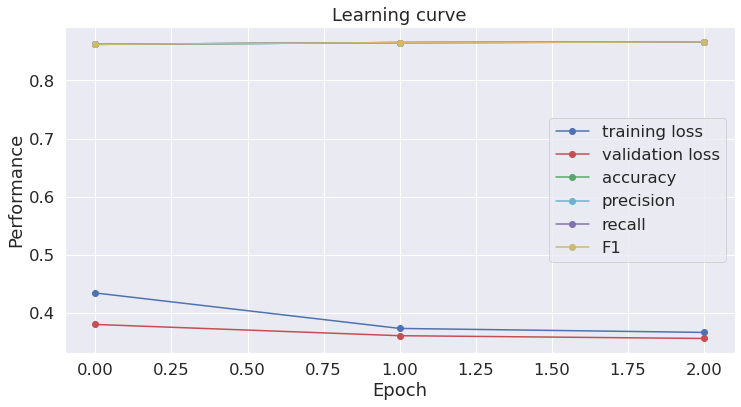

In [14]:

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=42, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42, test_size=0.2)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)



model = BertForTokenClassification.from_pretrained(
        "emilyalsentzer/Bio_ClinicalBERT",  # bert-base-cased
        num_labels=len(tag2idx),
        output_attentions=False,
        output_hidden_states=False,
        attention_probs_dropout_prob=0.3,  # 0.3
        hidden_dropout_prob=0.3  # 0.3
    )

model.cuda()

FULL_FINETUNING = False
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)




# from seqeval.metrics import f1_score, accuracy_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

accuracy_values, F1_values, precision_values, recall_values = [], [], [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    
    accuracy = accuracy_score(valid_tags, pred_tags)
    print("Validation Accuracy: {}".format(accuracy))
    accuracy_values.append(accuracy)
    
    precision = precision_score(valid_tags, pred_tags, labels=['0', '1'], average='micro')
    print("Validation Precision-Score: {}".format(precision))
    precision_values.append(precision)
    
    recall = recall_score(valid_tags, pred_tags, labels=['0', '1'], average='micro')
    print("Validation Recall-Score: {}".format(recall))
    recall_values.append(recall)
    
    F1 = f1_score(valid_tags, pred_tags, labels=['0', '1'], average='micro')
    print("Validation F1-Score: {}".format(F1))
    F1_values.append(F1)
    print()

    
# plotting the metrics

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")
plt.plot(accuracy_values, 'g-o', label="accuracy")
plt.plot(precision_values, 'c-o', label="precision")
plt.plot(recall_values, 'm-o', label="recall")
plt.plot(F1_values, 'y-o', label="F1")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Performance")
plt.legend()

plt.show()

    
